<a href="https://colab.research.google.com/github/yeowoobi/Aiffel_GoingDeeper/blob/main/CV06_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Going Deeper(CV) #06
---
## 나를 찾아줘 - Class Activation Map 만들기

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

# Helper libraries

import numpy as np
import matplotlib.pyplot as plt
import copy
import cv2
import PIL
from PIL import Image


print(tf.__version__)
print(np.__version__)
print(cv2.__version__)
print(PIL.__version__)

2.8.0
1.21.5
4.1.2
7.1.2


In [2]:
# GPU 사용 확인
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 1. CAM, Grad-CAM 용 모델 준비하기


## (1) 데이터셋 준비하기

In [3]:
# 데이터셋 다운로드
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
print('OK')

OK


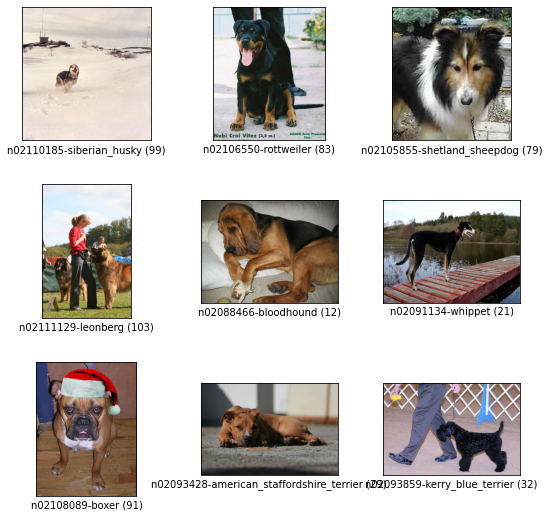

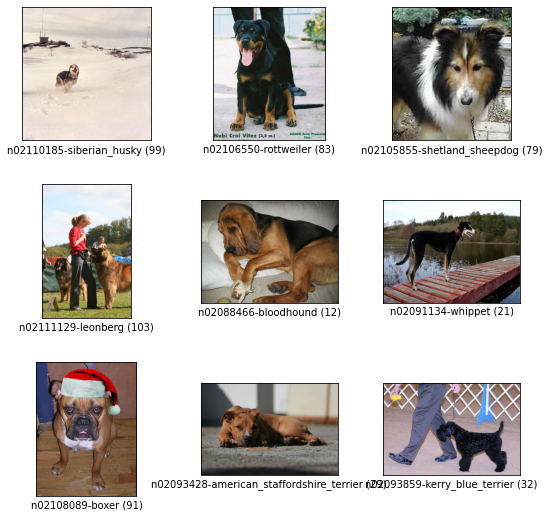

In [4]:
tfds.show_examples(ds_train, ds_info)

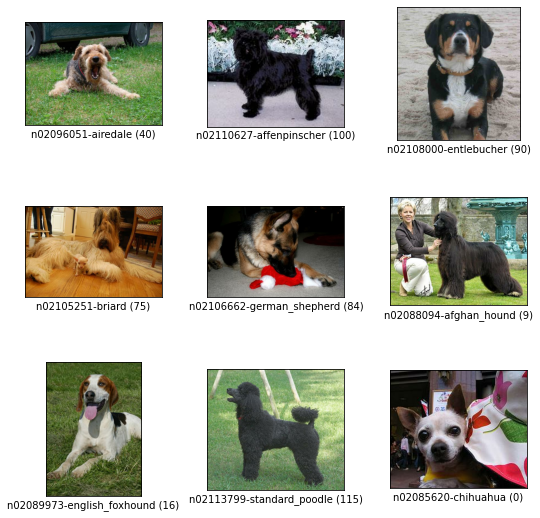

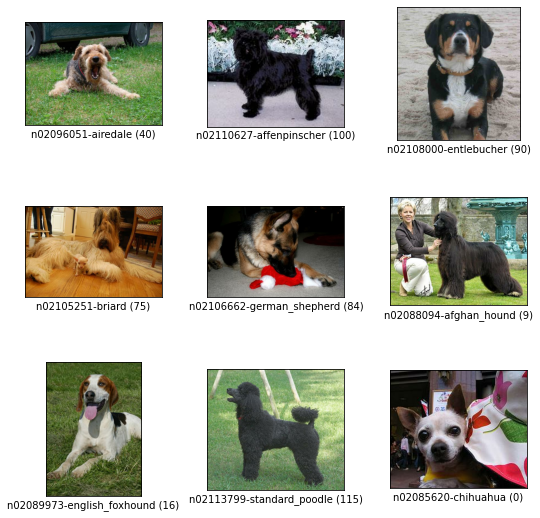

In [5]:
tfds.show_examples(ds_test, ds_info)

## (2) 물체의 위치정보

In [6]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

이미지의 `feature`을 확인해보면 `image`와 `label`은 이미지와 그에 해당하는 정답 클래스의 인덱스 임을 확인할 수 있다.  
`bbox`는 바운딩 박스를 의미하며 물체의 위치를 사각형 영역으로 표기하는 방식이다.

이 바운딩박스를 표시하는 방법으로 'xywh'와 'minmax'가 있다.  
<br>
>__'xywh'__
- 중심점을 x,y로 표기한 후 사각형의 너비와 높이를 표기하는 방법.
- `(x_center, y_center, width,height)`
>
> __'minmax'__
- 바운딩 박스를 이루는 좌표의 최소값과 최대값을 통해 표기하는 방법.
- `(x_min, x_max, y_min, y_max)`


## (3) CAM을 위한 모델 만들기

In [7]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,     # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224,3),
    pooling='avg',      # GAP은 매 채널별로 avseage pooling을 적용하기에 'avg'
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x) 
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

In [8]:
# 모델확인
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

## (4) CAM 모델 학습하기

In [9]:
# 데이터 전처리함수 만들기(normalizing, resizing)
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('OK')

OK


In [10]:
# 데이터셋에 전처리와 배치처리를 적용. 
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [12]:
# 모델 컴파일
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

print('OK')

OK


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [13]:
# 모델 학습
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=10,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 100s 123ms/step - loss: 2.2088 - accuracy: 0.4487 - val_loss: 3.2210 - val_accuracy: 0.2309
Epoch 2/10
750/750 [==============================] - 90s 120ms/step - loss: 0.6879 - accuracy: 0.8135 - val_loss: 1.0443 - val_accuracy: 0.6941
Epoch 3/10
750/750 [==============================] - 90s 120ms/step - loss: 0.2600 - accuracy: 0.9439 - val_loss: 0.9927 - val_accuracy: 0.7154
Epoch 4/10
750/750 [==============================] - 91s 121ms/step - loss: 0.0692 - accuracy: 0.9911 - val_loss: 0.9287 - val_accuracy: 0.7373
Epoch 5/10
750/750 [==============================] - 89s 119ms/step - loss: 0.0218 - accuracy: 0.9989 - val_loss: 0.9338 - val_accuracy: 0.7376
Epoch 6/10
750/750 [==============================] - 90s 120ms/step - loss: 0.0123 - accuracy: 0.9999 - val_loss: 0.9325 - val_accuracy: 0.7429
Epoch 7/10
750/750 [==============================] - 90s 119ms/step - loss: 0.0089 - accuracy: 1.0000 - val_loss: 0.9523 - val_a

In [18]:
history_cam_model.history

{'accuracy': [0.44874998927116394,
  0.8134999871253967,
  0.9439166784286499,
  0.9910833239555359,
  0.9989166855812073,
  0.999916672706604,
  1.0,
  1.0,
  1.0,
  1.0],
 'loss': [2.208775758743286,
  0.6878793239593506,
  0.2599802613258362,
  0.06915728747844696,
  0.02182886004447937,
  0.012271909974515438,
  0.008923247456550598,
  0.007068303879350424,
  0.005907174199819565,
  0.005146967247128487],
 'val_accuracy': [0.23085007071495056,
  0.694146454334259,
  0.7153684496879578,
  0.737272322177887,
  0.7376399040222168,
  0.742877185344696,
  0.7387902736663818,
  0.737155556678772,
  0.7407882213592529,
  0.7361240386962891],
 'val_loss': [3.220972776412964,
  1.0443226099014282,
  0.9927468299865723,
  0.9286824464797974,
  0.9337596893310547,
  0.9325419068336487,
  0.9522900581359863,
  0.9627912044525146,
  0.9609197378158569,
  0.998616099357605]}

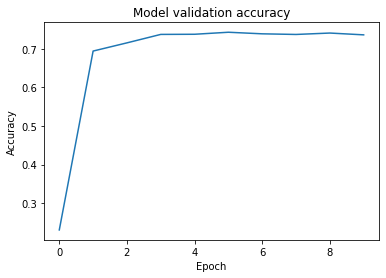

In [16]:
plt.plot(history_cam_model.history['val_accuracy'])
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [20]:
import os

# 가중치 저장
cam_model_path = '/content/drive/MyDrive/ColabData/Aiffel/GoingDeeper/class_activation_map/cam_model_2.h5'
cam_model.save(cam_model_path)
print("저장 완료!")

저장 완료!


# 2. CAM

CAM을 생성하기 위해 필요한 것은 아래와 같다.
- 특성맵
- 클래스별 확률을 얻기 위한 소프트맥스 레이어의 가중치
- 원하는 클래스의 출력값  

<br>
또한 모델이 이미지의 어떤 부분을 보는지 직관적으로 확인하기 위해 CAM을 입력 이미지 사이즈와 같게 만들어야 한다.

In [22]:
# 데이터셋에서 한 장씩 뽑을 수 있도록 하는 함수
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

print('OK')

OK


40


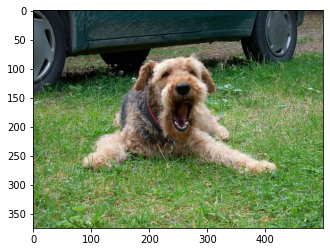

In [23]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [24]:
# cam_model_path = '/content/drive/MyDrive/ColabData/Aiffel/GoingDeeper/class_activation_map/cam_model.h5'
cam_model_path = '/content/drive/MyDrive/ColabData/Aiffel/GoingDeeper/class_activation_map/cam_model_2.h5'
cam_model = tf.keras.models.load_model(cam_model_path)
print('OK')

OK


In [25]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] # 마지막 모델의 weight activation을 가져오기
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score normalize.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize.
    return cam_image

print('OK')

OK


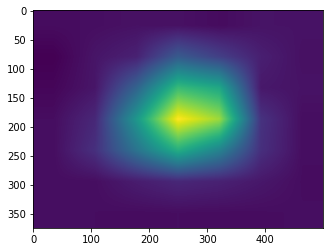

In [26]:
# CAM 이미지 생성
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [34]:
# CAM 이미지, 원본 이미지 합치는 함수
def visualize_cam_on_image(src1, src2, alpha=0.7): # alhpa : 원본 이미지, CAM 이미지의 투명도 조절
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

print('OK')

OK


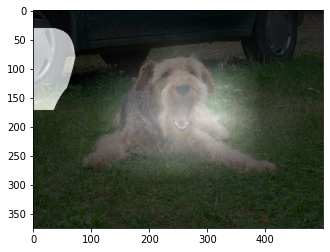

In [35]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

생성된 CAM이 개를 식별하는데 중요한 이미지 부분을 잘 포착하고 있는 것을 확인할 수 있다.

# 3. Grad-CAM

Grad-CAM은 관찰을 원하는 레이어와 정답 클래스에 대한 예측값 사이의 gradient를 구하고, 여기에 GAP연산을 적용해 관찰대상인 레이어의 채널별 가중치를 구한다.  
최종 CAM 이미지는 레이어 채널별 가중치와 레이어에서 나온 채널별 특성맵을 가중합해주어 구할 수 있다.  
<br>
CAM과 달리 Grad-CAM은 어떤 레이어든 CAM 이미지를 뽑아낼 수 있으므로, `activation_layer`의 이름을 받아 활용해야한다.

80


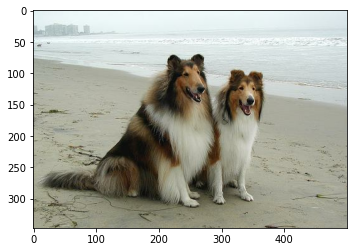

In [36]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [37]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용하기.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx]
        output = conv_output[0] 
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻는다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 가중치 구하기.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map 계산.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

print('OK')

OK


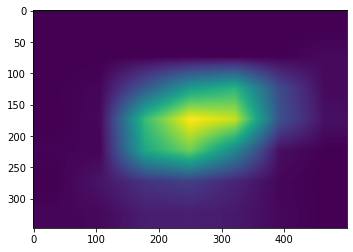

In [38]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

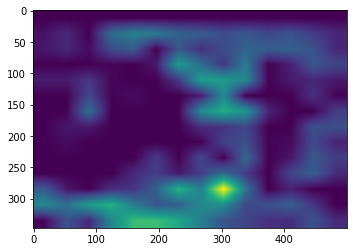

In [39]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

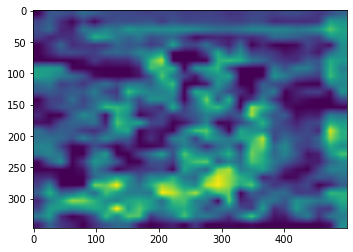

In [40]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

# 4. Detection with CAM , Grad-CAM

## (1) CAM

67


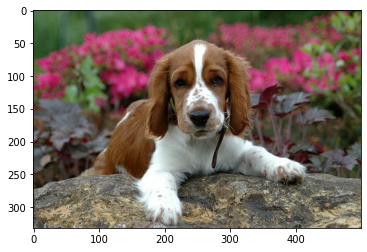

In [152]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

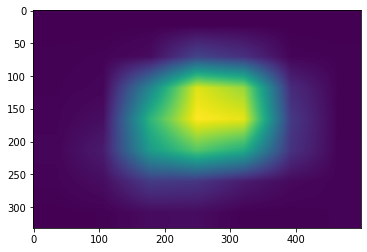

In [153]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [154]:
rect_1 = get_bbox(cam_image)
rect_1

array([[131, 350],
       [ 39, 109],
       [383, -21],
       [475, 219]])

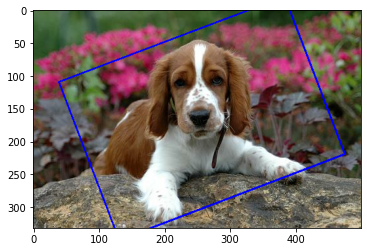

In [155]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect_1], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

## (2) Grad-CAM

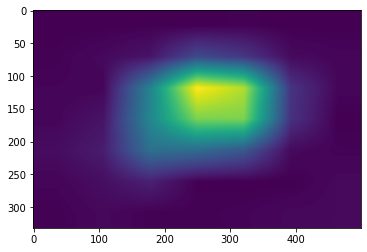

In [156]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

In [157]:
rect_2 = get_bbox(grad_cam_image)
rect_2

array([[ 82, 303],
       [ 35,  77],
       [419,  -3],
       [467, 221]])

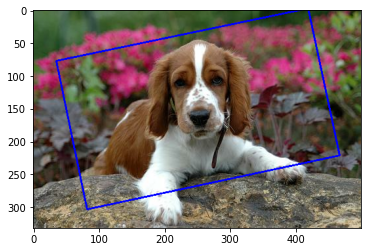

In [158]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect_2], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

# 5. Intersection Over Unuion
---
CAM과 Grad-CAM 두 가지 방법을 통해 바운딩 박스를 얻을 수 있었다.  
이 때, 정답 데이터인 바운딩 박스와 이를 어떻게 비교, 평가할 수 있을까?
<br><br>
__IOU__(Intersection Over Union)는 두 영역의 교집합인 __intersection__ 영역의 넓이를 두 영역의 합집합인 __union__영역으로 나누어준 값이다. 이를 통해 찾고자 하는 물건의 절대적인 면적과 상관없이, 영역을 정확하게 잘 찾아내었느지의 상댖거인 비율을 구할 수 있으므로, 모델이 영역을 잘 찾았는 지 비교하는 좋은 지표가 된다.
<br><br>
참고영상
- [C4W3L06 Intersection Over Union](https://www.youtube.com/watch?v=ANIzQ5G-XPE)

In [159]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

print('OK')

OK


In [160]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

print('OK')

OK


## (1) CAM

In [161]:
pred_bbox = rect_to_minmax(rect_1, item['image'])
pred_bbox

[-0.06325301204819277, 0.078, 1.0542168674698795, 0.95]

In [162]:
item['objects']['bbox']

array([[0.13554217, 0.146     , 0.9879518 , 0.826     ]], dtype=float32)

In [163]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.5948465451892587

## (2) Grad-CAM

In [164]:
pred_bbox = rect_to_minmax(rect_2, item['image'])
pred_bbox

[-0.009036144578313253, 0.07, 0.9126506024096386, 0.934]

In [165]:
item['objects']['bbox']

array([[0.13554217, 0.146     , 0.9879518 , 0.826     ]], dtype=float32)

In [166]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.6234895396369342

# 회고

## 모델에 대한 평가
---
이번 프로젝트는 설명가능한 AI, 즉 XAI에 대해 배워보며 특히 CAM, Grad-CAM 을 직접 구현, 사용해보고 IOU를 통해 결과를 비교하는 프로젝트였다.

|Activation Map|IOU|
|---|---|
|CAM|0.5948|
|Grad-CAM|0.6235|

평가결과 Grad-CAM이 CAM에 비하여 약간 더 성능이 좋았음을 확인할 수 있었는데, 기존 노드에서 처럼 Grad-CAM을 두번(?)적용할 경우 BBOX가 완전히 엉뚱한 위치에 생성되는 것을 보았다. 이에 Grad-CAM을 한번만 적용하여 다시 코드를 구성하였고 이 때의 성능이 CAM에 비하여 살짝 더 높았음을 확인할 수 있었다.

## 후기
---
CAM, Grad-CAM을 직접 구현하려고 코딩을 시도하였지만 결국에는 기존 노드의 코드를 많이 보게되었던 것 같다. 또한 처음 모델학습과정에서 Epoch을 2번만 돌렸을 시에는 CAM이 개의 얼굴에 위치하는 것을 보았음에도 불구하고 IOU가 낮게나와서 정확한 비교가 어려웠다.  
설명가능한 AI라고는 하지만 일단 모델의 정확도가 어느정도 나와주어야 XAI도 유의미한 결과를 나타내는 것이 아닌가 생각이 들었다.